# Rail Equip Accidents Iteration 2

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import acquire
import prepare
import explore
import preprocessing

#Visualization Imports
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

# modeling methods
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression, RFE 
import sklearn.preprocessing


In [2]:
#Acquire the Equipment Rail Data
df = acquire.get_equiprail()
df.shape

(22402, 146)

In [3]:
#Prepare the Equipment Rail Data
df = prepare.prep_equip_df(df)
df.shape

(10550, 37)

In [4]:
#View the first few rows
df.head(3)

,state_fips,railroad_company,accident_type,state_x,temp,visibility,weather,train_speed,train_direction,train_weight,...,region,typrr,lat,long,signal_type,date,season,state_y,state,year
incdtno,,,,,,,,,,,,,,,,,,,,,
GC0512102,48,BNSF,1,48,84,2,1,10,2.0,9811,...,5,1,29.7559,-95.2931,1,2012-05-05 08:00:00,Spring,54,WV,2012
GC0512105,48,BNSF,1,48,70,4,3,5,2.0,17157,...,5,1,29.500571,-95.597089,2,2012-05-11 02:25:00,Spring,54,WV,2012
GC0512106,48,BNSF,1,48,84,2,1,3,2.0,17304,...,5,1,31.446576,-96.20760600000001,2,2012-05-16 15:40:00,Spring,54,WV,2012


In [5]:
#Check the info
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10550 entries, GC0512102 to 137065
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   state_fips         10550 non-null  int64         
 1   railroad_company   10550 non-null  object        
 2   accident_type      10550 non-null  int64         
 3   state_x            10550 non-null  int64         
 4   temp               10550 non-null  int64         
 5   visibility         10550 non-null  int64         
 6   weather            10550 non-null  int64         
 7   train_speed        10550 non-null  int64         
 8   train_direction    10550 non-null  float64       
 9   train_weight       10550 non-null  int64         
 10  train_type         10550 non-null  object        
 11  track_type         10550 non-null  int64         
 12  front_engines      10550 non-null  int64         
 13  loadfrght_cars     10550 non-null  int64         
 14  lo

<AxesSubplot:>

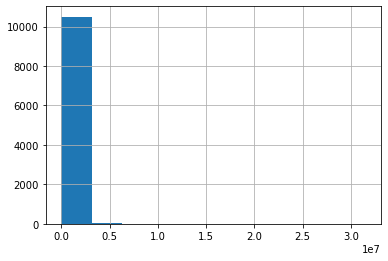

In [6]:
#Explore total damage distribuion...This is the target variable for it2
df.total_damage.hist()

In [7]:
def outlier_report(df, col_to_check=None):
    '''
    This function takes in a data frame and returns
    print statments stating the upper and lower bound outliers for 
    each column
    '''
    
    columns_to_check = []
    columns_to_check.append(col_to_check)
    
    for col in columns_to_check:
        quartile_01, quartile_03 = np.percentile(df[col], [25, 75])
        iqr = quartile_03 - quartile_01
    
        lower_bound = round(quartile_01 -(2 * iqr), 3)
        upper_bound = round(quartile_03 +(2 * iqr), 3)
    
        #df['outlier'] = df[col].apply(lambda x: outlier_label(x, lower_bound, upper_bound))
    

        print(f"The lower and upper bound of the range for '{col}' respectively is: {lower_bound} and {upper_bound}")

In [8]:
outlier_report(df, 'total_damage')

The lower and upper bound of the range for 'total_damage' respectively is: -123551.0 and 229345.25


In [9]:
#Return a dataframe with the outliers in total_damage removed
er_df = df[df.total_damage < 229345]
er_df.shape

(9264, 37)

<AxesSubplot:>

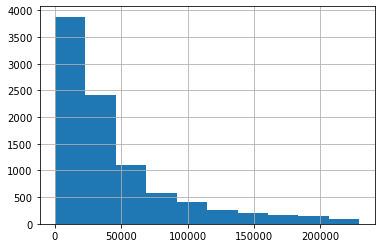

In [10]:
#Check the distribution of total damages after removing outliers
er_df.total_damage.hist()

In [11]:
#Subset the object columns to determine which columns to encode
obj_cols = preprocessing.get_object_cols(er_df)
obj_cols

['railroad_company',
 'train_type',
 'cause',
 'typrr',
 'lat',
 'long',
 'season',
 'state']

**Object Columns to encode as features:**
   - railroad_company

In [12]:
#Subject numeric columns for feature selection
num_cols = preprocessing.get_numeric_X_cols(er_df, obj_cols)
num_cols

['state_fips',
 'accident_type',
 'state_x',
 'temp',
 'visibility',
 'weather',
 'train_speed',
 'train_direction',
 'train_weight',
 'track_type',
 'front_engines',
 'loadfrght_cars',
 'loadpass_cars',
 'emptyfrght_cars',
 'emptypass_cars',
 'equip_damage',
 'track_damage',
 'total_killed',
 'total_injured',
 'max_speed',
 'total_damage',
 'engineers_onduty',
 'conductors_onduty',
 'brakemen_onduty',
 'region',
 'signal_type',
 'date',
 'state_y',
 'year']

## Prepare Dataframe for Regression

**Get Dummies for Railroad Company**

In [13]:
def create_dummies(df, object_cols):
    '''
    This function takes in a dataframe and list of object column names,
    and creates dummy variables of each of those columns. 
    It then appends the dummy variables to the original dataframe. 
    It returns the original df with the appended dummy variables. 
    '''
    
    # run pd.get_dummies() to create dummy vars for the object columns. 
    # we will drop the column representing the first unique value of each variable
    # we will opt to not create na columns for each variable with missing values 
    # (all missing values have been removed.)
    dummy_df = pd.get_dummies(df[object_cols], dummy_na=False, drop_first=True)
    
    # concatenate the dataframe with dummies to our original dataframe
    # via column (axis=1)
    df = pd.concat([df, dummy_df], axis=1)

    return df

In [14]:
#Drop object columns that I am not using in the model
er_df.drop(columns={'train_type','cause', 'typrr', 'lat', 'long','season','state'}, inplace=True)

In [15]:
#Get Dummies for Railroad Companies
object_cols = 'railroad_company'
er_df = create_dummies(er_df, object_cols)
er_df

,state_fips,railroad_company,accident_type,state_x,temp,visibility,weather,train_speed,train_direction,train_weight,...,brakemen_onduty,region,signal_type,date,state_y,year,BNSF,CSX,NS,UP
incdtno,,,,,,,,,,,,,,,,,,,,,
GC0512102,48,BNSF,1,48,84,2,1,10,2.0,9811,...,0.0,5,1,2012-05-05 08:00:00,54,2012,1,0,0,0
GC0512105,48,BNSF,1,48,70,4,3,5,2.0,17157,...,0.0,5,2,2012-05-11 02:25:00,54,2012,1,0,0,0
GC0512106,48,BNSF,1,48,84,2,1,3,2.0,17304,...,0.0,5,2,2012-05-16 15:40:00,54,2012,1,0,0,0
GC0512112,48,BNSF,1,48,70,4,1,5,3.0,14212,...,0.0,5,2,2012-05-31 03:36:00,54,2012,1,0,0,0
GC1212109,48,BNSF,1,48,65,4,2,10,2.0,0,...,0.0,5,2,2012-12-19 22:00:00,54,2012,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157439,33,ATK,9,33,29,4,6,79,1.0,0,...,1.0,1,1,2019-02-03 17:30:00,37,2019,0,0,0,0
159901,33,ATK,9,33,73,3,1,77,1.0,0,...,2.0,1,1,2019-07-06 17:41:00,37,2019,0,0,0,0
162555,33,ATK,9,33,32,2,3,46,2.0,0,...,2.0,1,1,2019-12-30 12:20:00,37,2019,0,0,0,0


In [16]:
#Drop Railroad_company
er_df.drop(columns={'railroad_company'}, inplace=True)

In [17]:
er_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9264 entries, GC0512102 to 137065
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   state_fips         9264 non-null   int64         
 1   accident_type      9264 non-null   int64         
 2   state_x            9264 non-null   int64         
 3   temp               9264 non-null   int64         
 4   visibility         9264 non-null   int64         
 5   weather            9264 non-null   int64         
 6   train_speed        9264 non-null   int64         
 7   train_direction    9264 non-null   float64       
 8   train_weight       9264 non-null   int64         
 9   track_type         9264 non-null   int64         
 10  front_engines      9264 non-null   int64         
 11  loadfrght_cars     9264 non-null   int64         
 12  loadpass_cars      9264 non-null   int64         
 13  emptyfrght_cars    9264 non-null   int64         
 14  emp

In [18]:
#Need to drop datetime
er_df.drop(columns={'date'}, inplace=True)

**Split the Data**

In [19]:
def split_stratify_continuous(df, target, bins=8):
    '''
    This function splits a data frame into train, test, validate
    and startifies by a continuous target variable.
    '''
    binned_y = pd.cut(df[target], bins=bins, labels=list(range(bins)))
    df["bins"] = binned_y
    train_validate, test = train_test_split(df, stratify=df["bins"], test_size=0.2, random_state=123)
    train, validate = train_test_split(train_validate, stratify=train_validate["bins"], test_size=0.3, random_state=123)
    train = train.drop(columns=["bins"])
    validate = validate.drop(columns=["bins"])
    test = test.drop(columns=["bins"])
    return train, test, validate

In [20]:
train, test, validate = split_stratify_continuous(er_df, target='total_damage', bins=8)
train.shape

(5187, 32)

In [21]:
def train_validate_test(train, validate, test, target, bins=5):
    '''
    this function takes in a dataframe and splits it into 3 samples, 
    a test, which is 20% of the entire dataframe, 
    a validate, which is 24% of the entire dataframe,
    and a train, which is 56% of the entire dataframe. 
    It then splits each of the 3 samples into a dataframe with independent variables
    and a series with the dependent, or target variable. 
    The function returns 3 dataframes and 3 series:
    X_train (df) & y_train (series), X_validate & y_validate, X_test & y_test. 
    '''
    
    # split train into X (dataframe, drop target) & y (series, keep target only)
    X_train = train.drop(columns=[target])
    y_train = train[target]
    
    # split validate into X (dataframe, drop target) & y (series, keep target only)
    X_validate = validate.drop(columns=[target])
    y_validate = validate[target]
    
    # split test into X (dataframe, drop target) & y (series, keep target only)
    X_test = test.drop(columns=[target])
    y_test = test[target]
    
    return X_train, y_train, X_validate, y_validate, X_test, y_test

In [22]:
X_train, y_train, X_validate, y_validate, X_test, y_test = train_validate_test(train, validate, test, 'total_damage', bins=8)

**Scale the Data**

In [23]:
def get_numeric_X_cols(X_train, object_cols):
    '''
    takes in a dataframe and list of object column names
    and returns a list of all other columns names, the non-objects. 
    '''
    numeric_cols = [col for col in X_train.columns.values if col not in object_cols]
    
    return numeric_cols

def min_max_scale(X_train, X_validate, X_test, numeric_cols):
    '''
    this function takes in 3 dataframes with the same columns, 
    a list of numeric column names (because the scaler can only work with numeric columns),
    and fits a min-max scaler to the first dataframe and transforms all
    3 dataframes using that scaler. 
    it returns 3 dataframes with the same column names and scaled values. 
    '''
    # create the scaler object and fit it to X_train (i.e. identify min and max)
    # if copy = false, inplace row normalization happens and avoids a copy (if the input is already a numpy array).


    scaler = sklearn.preprocessing.MinMaxScaler()
    scaler.fit(X_train[numeric_cols])

    #scale X_train, X_validate, X_test using the mins and maxes stored in the scaler derived from X_train. 
    # 
    X_train_scaled_array = scaler.transform(X_train[numeric_cols])
    X_validate_scaled_array = scaler.transform(X_validate[numeric_cols])
    X_test_scaled_array = scaler.transform(X_test[numeric_cols])

    # convert arrays to dataframes
    X_train_scaled = pd.DataFrame(X_train_scaled_array, 
                                  columns=numeric_cols).\
                                  set_index([X_train.index.values])

    X_validate_scaled = pd.DataFrame(X_validate_scaled_array, 
                                     columns=numeric_cols).\
                                     set_index([X_validate.index.values])

    X_test_scaled = pd.DataFrame(X_test_scaled_array, 
                                 columns=numeric_cols).\
                                 set_index([X_test.index.values])

    
    return X_train_scaled, X_validate_scaled, X_test_scaled

In [24]:
numeric_cols = get_numeric_X_cols(X_train, object_cols)
numeric_cols

['state_fips',
 'accident_type',
 'state_x',
 'temp',
 'visibility',
 'weather',
 'train_speed',
 'train_direction',
 'train_weight',
 'track_type',
 'front_engines',
 'loadfrght_cars',
 'loadpass_cars',
 'emptyfrght_cars',
 'emptypass_cars',
 'equip_damage',
 'track_damage',
 'total_killed',
 'total_injured',
 'max_speed',
 'engineers_onduty',
 'conductors_onduty',
 'brakemen_onduty',
 'region',
 'signal_type',
 'state_y',
 'year',
 'BNSF',
 'CSX',
 'NS',
 'UP']

In [25]:
X_train_scaled, X_validate_scaled, X_test_scaled =  min_max_scale(X_train, X_validate, X_test, numeric_cols)
X_train_scaled.shape

(5187, 31)

**Feature Selection**

In [27]:
from sklearn.feature_selection import SelectKBest, f_regression

# parameters: f_regression stats test, give me 4 features
f_selector = SelectKBest(f_regression, k=10)

# find the top 4 X's correlated with y
f_selector.fit(X_train_scaled, y_train)

# boolean mask of whether the column was selected or not. 
feature_mask = f_selector.get_support()

# get list of top K features. 
f_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()
print(f'SelectKBest preferences the following as the top 4 features for predicting taxvaluedollarcnt: {f_feature}')

SelectKBest preferences the following as the top 4 features for predicting taxvaluedollarcnt: ['accident_type', 'train_weight', 'front_engines', 'loadfrght_cars', 'loadpass_cars', 'equip_damage', 'track_damage', 'region', 'NS', 'UP']


---

## Modeling

In [28]:
import pandas as pd
import numpy as np

from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression 
from math import sqrt
import math
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from statsmodels.formula.api import ols

def plot_residuals(actual, predicted):

    residuals = actual - predicted
    plt.hlines(0, actual.min(), actual.max(), ls=':')
    plt.scatter(actual, residuals)
    plt.ylabel('residual ($y - \hat{y}$)')
    plt.xlabel('actual value ($y$)')
    plt.title('Actual vs Residual')
    plt.show()


def regression_errors(actual, predicted):
    return pd.Series({
        'sse': sse(actual, predicted),
        'ess': ess(actual, predicted),
        'tss': tss(actual),
        'mse': mse(actual, predicted),
        'rmse': rmse(actual, predicted),
        'r^2': (ess(actual, predicted))/(tss(actual)),
    })


def residuals(actual, predicted):
    return actual - predicted

def sse(actual, predicted):
    return (residuals(actual, predicted) **2).sum()

def mse(actual, predicted):
    n = actual.shape[0]
    return sse(actual, predicted) / n

def rmse(actual, predicted):
    return math.sqrt(mse(actual, predicted))

def ess(actual, predicted):
    return ((predicted - actual.mean()) ** 2).sum()

def tss(actual):
    return ((actual - actual.mean()) ** 2).sum()


def baseline_mean_errors(actual):
    predicted = actual.mean()
    return {
        'sse': sse(actual, predicted),
        'mse': mse(actual, predicted),
        'rmse': rmse(actual, predicted),
    }

def baseline_median_errors(actual):
    predicted = actual.median()
    return {
        'sse': sse(actual, predicted),
        'mse': mse(actual, predicted),
        'rmse': rmse(actual, predicted),
    }

def better_than_baseline(actual, predicted):
    rmse_baseline = rmse(actual, actual.mean())
    rmse_model = rmse(actual, predicted)
    return rmse_model < rmse_baseline

**Baseline Model**

In [29]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)
X_test = pd.DataFrame(X_test)

# 1. Predict total_damage_pred_mean
total_damage_pred_mean = y_train['total_damage'].mean()
y_train['total_damage_pred_mean'] = total_damage_pred_mean
y_validate['total_damage_pred_mean'] = total_damage_pred_mean
y_test['total_damage_pred_mean'] = total_damage_pred_mean

# 2. compute total_damage_pred_median
total_damage_pred_median = y_train['total_damage'].median()
y_train['total_damage_pred_median'] = total_damage_pred_median
y_validate['total_damage_pred_median'] = total_damage_pred_median
y_test['total_damage_pred_median'] = total_damage_pred_median

In [30]:
#Evaluate the baseline model using the mean
baseline_mean_errors(y_train.total_damage)

{'sse': 10529973289476.895,
 'mse': 2030070038.457084,
 'rmse': 45056.29854367849}

In [31]:
#Evaluate the baseline model using the median
baseline_median_errors(y_train.total_damage)

{'sse': 12390898866795.0,
 'mse': 2388837259.8409486,
 'rmse': 48875.732831753514}

In [32]:
#Now that I have established the mean as the baseline, I will drop the median and rename baseline to yhat_baseline
y_train.drop(columns={'total_damage_pred_median'}, inplace=True)
y_validate.drop(columns={'total_damage_pred_median'}, inplace=True)
y_test.drop(columns={'total_damage_pred_median'}, inplace=True)

y_train.rename(columns={'total_damage_pred_mean': 'yhat_baseline'}, inplace=True)
y_validate.rename(columns={'total_damage_pred_mean': 'yhat_baseline'}, inplace=True)
y_test.rename(columns={'total_damage_pred_mean': 'yhat_baseline'}, inplace=True)
y_train.head()

,total_damage,yhat_baseline
incdtno,,
0715ST015,17222,46383.151533
1118HO016,14435,46383.151533
CA0719102,65630,46383.151533
RD0118204,50000,46383.151533
000181808,86513,46383.151533


**Linear Regression (OLS) Model**

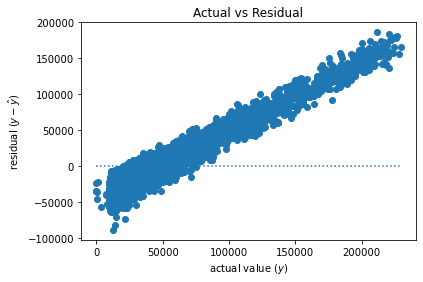

sse     9.862764e+12
ess     6.672093e+11
tss     1.052997e+13
mse     1.901439e+09
rmse    4.360549e+04
r^2     6.336287e-02
dtype: float64

In [34]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train_scaled[['accident_type', 'train_weight', 'front_engines', 'loadfrght_cars', 
                       'loadpass_cars', 'region', 'NS', 'UP']], y_train.total_damage)

# predict train
y_train['yhat_lm'] = lm.predict(X_train_scaled[['accident_type', 'train_weight', 'front_engines', 'loadfrght_cars', 
                       'loadpass_cars', 'region', 'NS', 'UP']])

# compute residuals
y_train['residual'] = y_train['yhat_lm'] - y_train['total_damage']
y_train['baseline_residual'] = y_train['yhat_baseline'] - y_train['total_damage']

#Use evaluate model to visualize the residuals
plot_residuals(y_train.total_damage, y_train.yhat_lm)

#Retrieve evaluation metrics for Linear Regression Model on in-sample data
regression_errors(y_train.total_damage, y_train.yhat_lm)

**Takeaways:**
- Barely beats baseline

**Tweedie Regressor GLM Model**

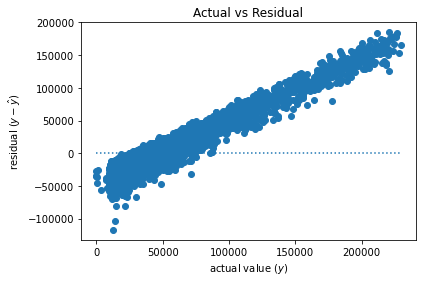

sse     9.855349e+12
ess     6.805764e+11
tss     1.052997e+13
mse     1.900010e+09
rmse    4.358910e+04
r^2     6.463230e-02
dtype: float64

In [39]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train_scaled[['accident_type', 'train_weight', 'front_engines', 'loadfrght_cars', 
                       'loadpass_cars','NS', 'UP']], y_train.total_damage)

# predict train
y_train['yhat_glm'] = glm.predict(X_train_scaled[['accident_type', 'train_weight', 'front_engines', 'loadfrght_cars', 
                       'loadpass_cars', 'NS', 'UP']])

#Use evaluate model to visualize the residuals
plot_residuals(y_train.total_damage, y_train.yhat_glm)

#How does the GLM model perform on in-sample data?
regression_errors(y_train.total_damage, y_train.yhat_glm)


**Takeaways**
   - GLM Model does not achieve significantly better than baseline